In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particle

In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-4, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 4.082         
Matching: model call n. 22               
Optimize - end penalty:  4.11888e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

### Build a matched beam distribution

In [7]:
# Define number of turns and number of particles for the simulation
num_turns = 5000
num_particles = 1500
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum offset distribution (mean 15e-4, std spread 4e-4)
delta = np.random.normal(loc=15e-4, scale=4e-4, size=num_particles)

# Particles arrival time spread over one turn
zeta = np.random.uniform(size=num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=0.52e-6, nemitt_y=1e-8,
)

# save initial state
p0 = particles.copy()

In [8]:
# Get details for existing Betatron Core element in the imported CNAO lattice
tab = line.get_table()
myRow = tab.rows['s4_015a_bec']
myRow.cols['s','name','element_type','s_start','s_center','s_end']

Table: 1 row, 6 cols
name                    s element_type       s_start      s_center         s_end
s4_015a_bec        29.084 Drift               29.084        29.834        30.584

### Define time-dependent bevior of extraction sextupole

In [9]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 0.5e-3], y=[0, 0, 1.])

line.vars['sr'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['sr']._expr

(-3.3015954716218534 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [10]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [11]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads='auto')
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

In [12]:
# User-defined quantity to be logged (functions executed at every turn, output is automatically logged).
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('sr',                         # vars to be logged
             intensity=measure_intensity)  # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [13]:
line.enable_time_dependent_vars = True

### Track!

In [14]:
line.track(particles, num_turns=num_turns, with_progress=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

### Plot logged quantities

Text(0, 0.5, 'Intensity [$p^+$]')

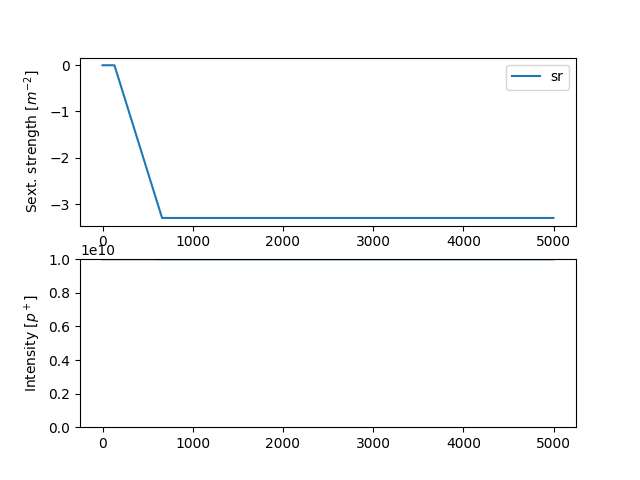

In [15]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(line.log_last_track['sr'], label='sr')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

In [16]:
# Alive percentage after the tracking only with the resonance sextupole ramp-up
print(f"Percentage of alive particles after sextupole ramp-up:\n{100*(line.log_last_track["intensity"][-1] / beam_intensity)} %")

Percentage of alive particles after sextupole ramp-up:
99.93333333333332 %


### Plot particles after tracking

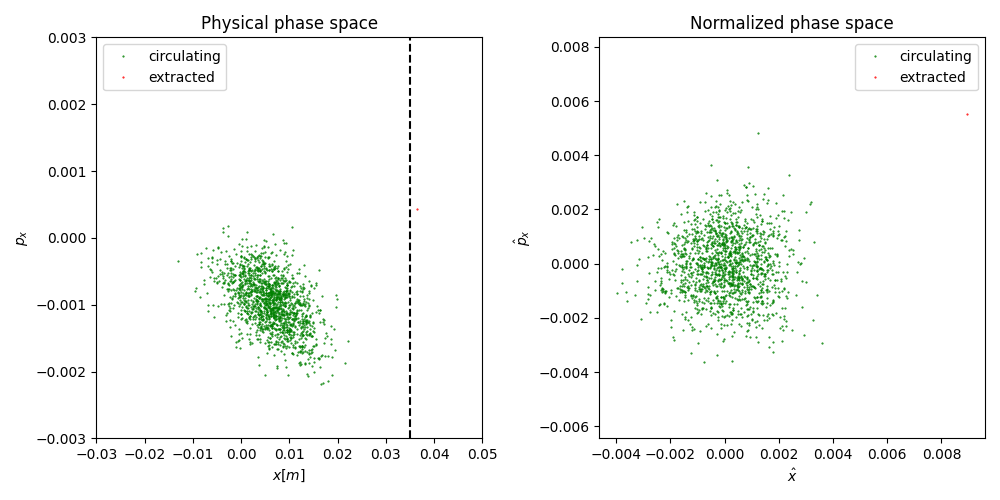

In [17]:
mask_alive1 = particles.state>0
mask_lost1 = ~mask_alive1

# Get particles normalized coordinates
nc0 = tw.get_normalized_coordinates(particles)

plt.figure(figsize=(10, 5))
ax_geom = plt.subplot(1, 2, 1, title='Physical phase space')
ax_norm = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_geom.plot(particles.x[mask_alive1], particles.px[mask_alive1],
         '.', markersize=1, color='green', label='circulating')
ax_geom.plot(particles.x[mask_lost1], particles.px[mask_lost1],
         '.', markersize=1, color='red', label='extracted')
ax_geom.set_xlim(-0.03, 0.05); ax_geom.set_ylim(-3e-3, 3e-3)
ax_geom.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_geom.set_xlabel(r'${x} [m]$')
ax_geom.set_ylabel(r'${p}_x$')
ax_geom.legend()

ax_norm.plot(nc0.x_norm[mask_alive1], nc0.px_norm[mask_alive1],
         '.', markersize=1, color='green', label='circulating')
ax_norm.plot(nc0.x_norm[mask_lost1], nc0.px_norm[mask_lost1],
         '.', markersize=1, color='red', label='extracted')
ax_norm.set_aspect('equal', adjustable='datalim')
ax_norm.set_xlabel(r'$\hat{x}$')
ax_norm.set_ylabel(r'$\hat{p}_x$')
ax_norm.legend()

plt.tight_layout()

plt.show()

### Create a simple Betatron Core exciter

In [18]:
# Define new element type for betatron core excitation
class BetatronCoreExciter:
    def __init__(self):
        
        self.kick = 0
   
    def track(self, p):
        
        # Apply the delta_per_turn only to active (alive) particles
        p.delta[p.state > 0] += self.kick

In [19]:
# Install the custom element (thin element) in the center of the actual Betatron Core.
# This way the actual Betatron Core of the CNAO lattice (which is considered a drift) is sliced.
line.discard_tracker()
line.insert_element('core_exc', BetatronCoreExciter(), at_s=29.834)
line.build_tracker(_context=ctx)

Slicing line:   0%|          | 0/429 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [20]:
# Define a function that activates the core kick after 1.5e-3 seconds
line.functions['fun_corekick'] = xt.FunctionPieceWiseLinear(
    x=[0, 1.5e-3, 1.5001e-3],
    y=[0, 0,      -0.6e-6]) 

In [21]:
# Create a variable linked to the current turn time
line.vars['corekick'] = line.functions['fun_corekick'](line.vars['t_turn_s'])

# Assign the variable to the class attribute
line.element_refs['core_exc'].kick = line.vars['corekick']

### Reset the model

In [22]:
# Reset simulation time
line.vars['t_turn_s'] = 0

In [23]:
# Back to initial particles distribution
p = p0.copy()

### Log excitation parameters

In [24]:
log = xt.Log(
    'sr', 't_turn_s',              # vars to be logged
    'corekick',
    intensity=measure_intensity)   # user-defined functions to be logged

### Track!

In [25]:
line.track(p, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [26]:
# Record particle coordinates turn by turn
rec = line.record_last_track

### Plot logged quantities

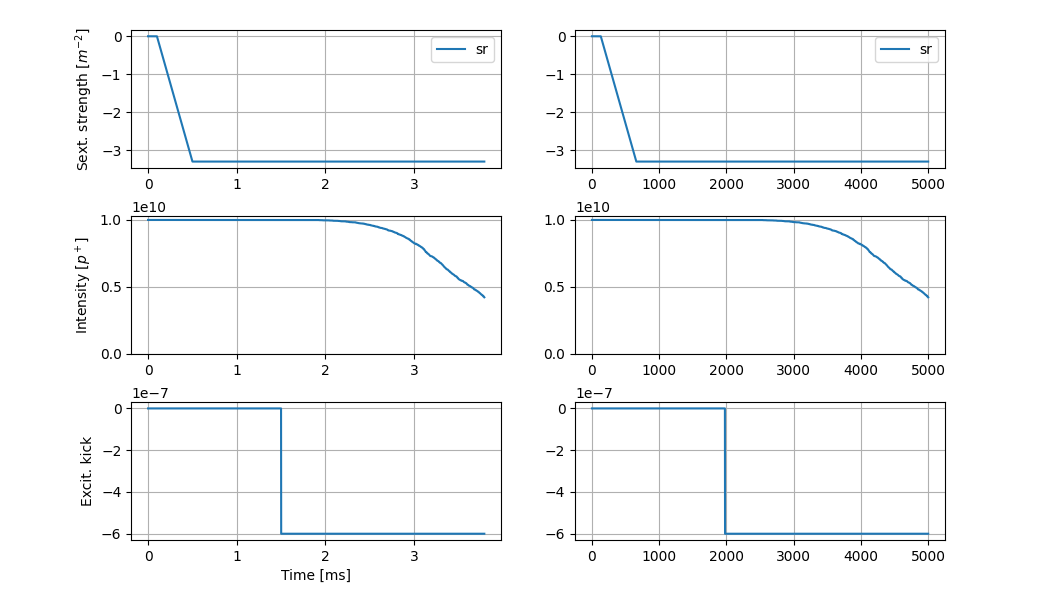

In [27]:
plt.figure(figsize=(10.5, 6))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(3,2,1)
plt.plot(t_ms, line.log_last_track['sr'], label='sr')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()
plt.grid()

ax2 = plt.subplot(3,2,2)
plt.plot(line.log_last_track['sr'], label='sr')
plt.legend()
plt.grid()

ax3 = plt.subplot(3,2,3, sharex=ax1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')
plt.grid()

ax4 = plt.subplot(3,2,4, sharex=ax2)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.grid()

ax5 = plt.subplot(3,2,5, sharex=ax1)
plt.plot(t_ms, line.log_last_track['corekick'])
plt.ylabel('Excit. kick')
plt.xlabel('Time [ms]')
plt.grid()

ax6 = plt.subplot(3,2,6, sharex=ax2)
plt.plot(line.log_last_track['corekick'])
plt.grid()

plt.subplots_adjust(top=.95, bottom=.1, hspace=.35)

In [47]:
# Alive percentage after tracking with Betatron core and resonance sextupole ramp-up
print(f"Percentage of alive particles after Betatron core:\n{100*(line.log_last_track["intensity"][-1] / beam_intensity)} %")

Percentage of alive particles after Betatron core:
42.26666666666666 %


### Plot particles after tracking

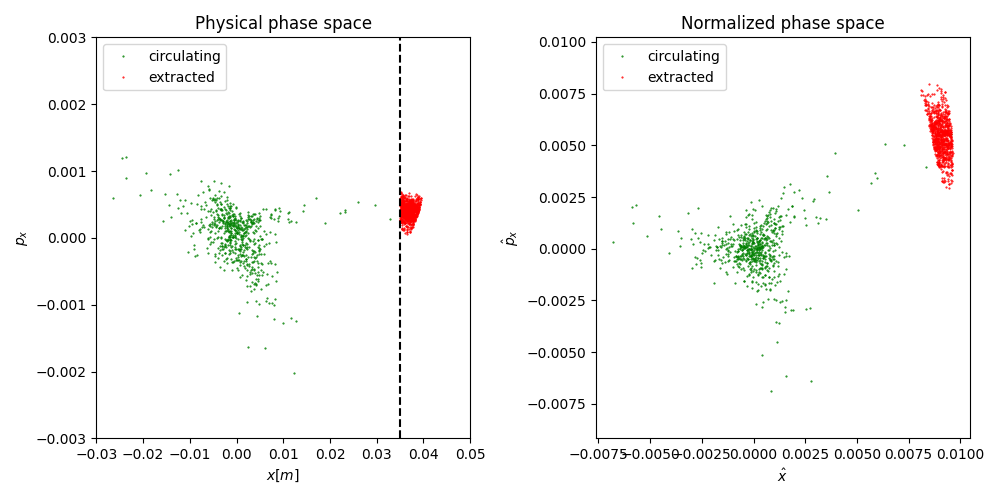

In [29]:
mask_alive2 = p.state>0
mask_lost2 = ~mask_alive2

# Get particles normalized coordinates
nc1 = tw.get_normalized_coordinates(p)

plt.figure(figsize=(10, 5))
ax_g = plt.subplot(1, 2, 1, title='Physical phase space')
ax_n = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_g.plot(p.x[mask_alive2], p.px[mask_alive2],
         '.', markersize=1, color='green', label='circulating')
ax_g.plot(p.x[mask_lost2], p.px[mask_lost2],
         '.', markersize=1, color='red', label='extracted')
ax_g.set_xlim(-0.03, 0.05); ax_g.set_ylim(-3e-3, 3e-3)
ax_g.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_g.set_xlabel(r'${x} [m]$')
ax_g.set_ylabel(r'${p}_x$')
ax_g.legend()

ax_n.plot(nc1.x_norm[mask_alive2], nc1.px_norm[mask_alive2],
         '.', markersize=1, color='green', label='circulating')
ax_n.plot(nc1.x_norm[mask_lost2], nc1.px_norm[mask_lost2],
         '.', markersize=1, color='red', label='extracted')
ax_n.set_aspect('equal', adjustable='datalim')
ax_n.set_xlabel(r'$\hat{x}$')
ax_n.set_ylabel(r'$\hat{p}_x$')
ax_n.legend()

plt.tight_layout()

plt.show()

In [30]:
# Extracted particles' px spread at electrostatic septum in mrad
print(f'Maximum px spread of extracted beam:\n{(p.px[mask_lost2].max() - p.px[mask_lost2].min()) * 1e3} mrad')

Maximum px spread of extracted beam:
0.6284800625235761 mrad


## Dynamic Steinbach

In [31]:
# Convert to numpy array (in order to multiply)
sr = np.array(line.log_last_track['sr'])

# We calculate the normalized sextupole strength S (np array with a value for each turn)
norm_sext_strength = 0.5 * (tw['betx', 's8_028a_sxr'])**1.5 * line['s8_028a_sxr'].length * sr

**NOTE Below:** Because the momentum spread of the beam is very small or displaced from the resonance tune, we create a wider distribution to calculate the resonance lines with smaller size than the number of particles. This helps to calculate the resonance amplitude faster. 

** This may sacrifice a little bit the linearity of the line (with sample_size=200 we have a decent linearity and the calculation is fast enough)

In [32]:
# Define the size of the new distribution
sample_size = 200
# Create the new Gaussian distribution centered on resonance tune
delta2 = np.random.normal(loc=((5/3 - tw.qx) / tw.dqx), scale=17e-4, size=sample_size)

In [33]:
# Calculation of the resonance amplitude for every turn (it is changing because of the sextupole ramp up)
res_amplitude = np.zeros((sample_size, num_turns))

for jj in range(0, num_turns):
    for ii in range(0, sample_size):
        # We calculate the resonance amplitude
        res_amplitude[ii,jj] = np.sqrt(48*np.pi*np.sqrt(3)) * np.abs(tw.dqx/norm_sext_strength[jj]) * np.abs(delta2[ii])

/tmp/ipykernel_14882/4072993784.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  res_amplitude[ii,jj] = np.sqrt(48*np.pi*np.sqrt(3)) * np.abs(tw.dqx/norm_sext_strength[jj]) * np.abs(delta2[ii])


#### Get normalized coordinates for lost particles according to particle ids

In [34]:
# Step 1: Get the lost particle_ids
lost_ids = rec.particle_id[:,0][rec.state[:,-1] == 0] 

# Step 2: Create a mapping from particle_id to index in nc
id_to_index1 = {pid1: idx1 for idx1, pid1 in enumerate(nc0.particle_id)}

# Step 3: Get indices in nc that correspond to lost_ids
lost_indices = np.array([id_to_index1[pid1] for pid1 in lost_ids])

# Step 4: Select the corresponding nc.x and nc.px values
nc_x_lost = nc0.x_norm[lost_indices]
nc_px_lost = nc0.px_norm[lost_indices]

# Calculation of the normalized amplitude for lost particles
norm_amplitude_lost = np.sqrt(nc_x_lost**2 + nc_px_lost**2)

#### Get normalized coordinates for alive particles according to particle ids

In [35]:
# Step 1: Get the alive particle_ids
alive_ids = rec.particle_id[:,0][rec.state[:,-1] == 1] 

# Step 2: Create a mapping from particle_id to index in nc
id_to_index2 = {pid2: idx2 for idx2, pid2 in enumerate(nc0.particle_id)}

# Step 3: Get indices in nc that correspond to alive_ids
alive_indices = np.array([id_to_index2[pid2] for pid2 in alive_ids])

# Step 4: Select the corresponding nc.x and nc.px values
nc_x_alive = nc0.x_norm[alive_indices]
nc_px_alive = nc0.px_norm[alive_indices]

# Calculation of the normalized amplitude for alive particles
norm_amplitude_alive = np.sqrt(nc_x_alive**2 + nc_px_alive**2)

### Plot for initial amplitude discriminating between alive and lost particles

In [36]:
# Sort indices based on p.delta
sort_idx = np.argsort(delta2)

# Apply sorting to both arrays
res_tune_sorted = delta2[sort_idx] * tw.dqx + 5/3
amplitude_sorted = res_amplitude[sort_idx]

Text(0, 0.5, 'Normalized Amplitude')

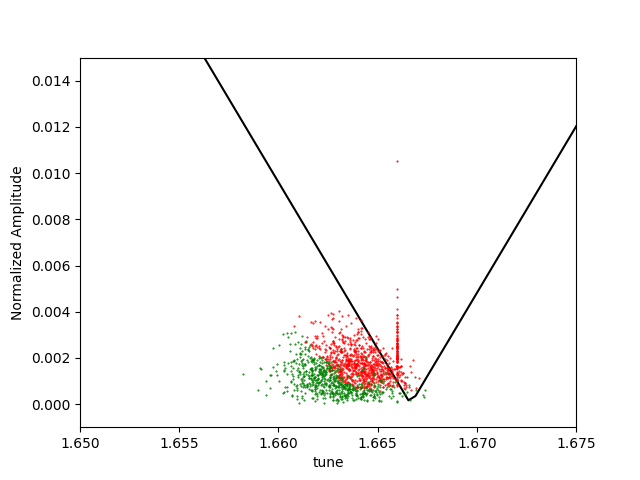

In [44]:
# We choose a turn to plot
turn = 3500

# Plot for chosen turn
plt.figure()
plt.plot(res_tune_sorted, amplitude_sorted[:,turn], '-', markersize=1, color='k')
plt.plot(rec.delta[:,turn][lost_ids] * tw.dqx + tw.qx, norm_amplitude_lost, '.', markersize=1, color='red')
plt.plot(rec.delta[:,turn][alive_ids] * tw.dqx + tw.qx, norm_amplitude_alive, '.', markersize=1, color='green')
plt.xlim(1.65, 1.675); plt.ylim(-1e-3, 0.015)
plt.xlabel('tune')
plt.ylabel('Normalized Amplitude')

#### Animated Steinbach diagram for the whole simulation

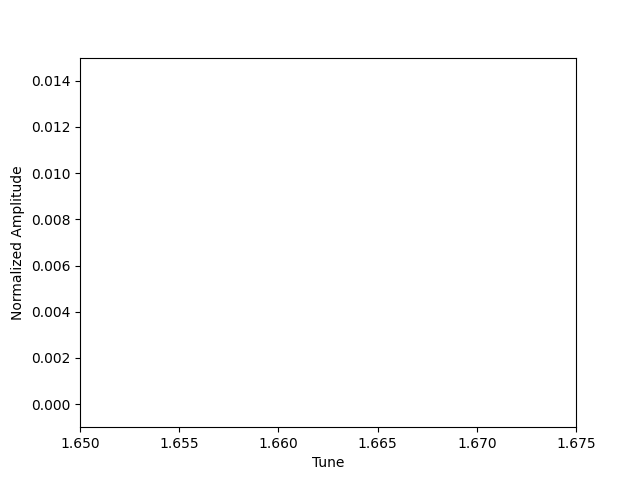

In [42]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line0, = ax.plot([], [], '.', markersize=1, color='red')
line1, = ax.plot([], [], '.', markersize=1, color='green')
line2, = ax.plot([], [], '-', linewidth=1, color='k')
text_label = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlim(1.65, 1.675)
ax.set_ylim(-1e-3, 0.015)
ax.set_xlabel("Tune")
ax.set_ylabel("Normalized Amplitude")

# Update function for animation
def update(frame):
    line0.set_data(rec.delta[:,frame][lost_ids] * tw.dqx + tw.qx, norm_amplitude_lost)
    line1.set_data(rec.delta[:,frame][alive_ids] * tw.dqx + tw.qx, norm_amplitude_alive)
    line2.set_data(res_tune_sorted, amplitude_sorted[:, frame])
    if 135 <= frame <= 660:
        text_label.set_text(f'Turn {frame} — Sextupole Ramp Up')
    elif 660 < frame < 1970:
        text_label.set_text(f'Turn {frame}')
    elif frame < 135:
        text_label.set_text(f'Turn {frame}')
    else:
        text_label.set_text(f'Turn {frame} — Betatron Core')
    return line, line2, text_label

ani = FuncAnimation(fig, update, frames=range(0, num_turns, 5), interval=30, blit=True, repeat=False)

plt.show()

In the animated Steinbach Diagram above I plot in red the particles that are going to be extracted and the alive particles are in green. As we can see, the normalised amplitude for every particle used in this plot was the initial one. Below I will take into consideration the normilised amplitude evolution for every particle and every turn.

### Plot for increasing amplitude

**NOTE Below:** In ``nc2_amp`` after the loss of each particle we get a NaN value for its remaining turns in the simulation.

In [39]:
# Get normalized coordinates for every particle in every turn
nc2 = tw.get_normalized_coordinates(rec)

# Calculate normalized amplitude for every particle at every turn, untill it's lost
nc2_amp = np.sqrt(nc2.x_norm**2 + nc2.px_norm**2)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


#### Animated Steinbach diagram for the whole simulation

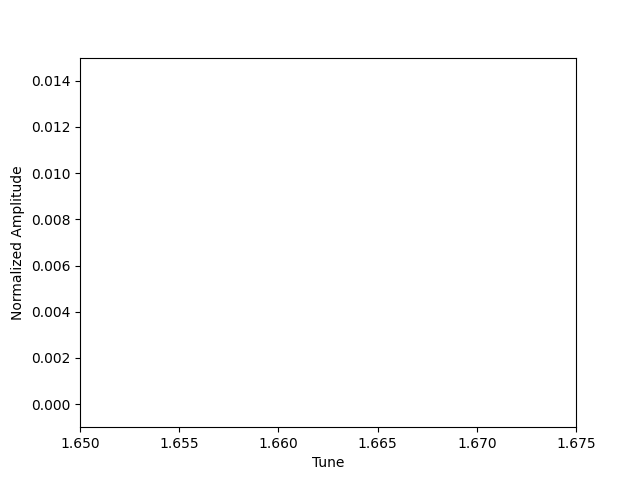

In [43]:
fig, ax = plt.subplots()
line1, = ax.plot([], [], '.', markersize=1, color='green')
line2, = ax.plot([], [], '-', linewidth=1, color='k')
text_label = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlim(1.65, 1.675)
ax.set_ylim(-1e-3, 0.015)
ax.set_xlabel("Tune")
ax.set_ylabel("Normalized Amplitude")

# Update function for animation
def update(frame):
    line1.set_data(rec.delta[:,frame] * tw.dqx + tw.qx, nc2_amp[:,frame])
    line2.set_data(res_tune_sorted, amplitude_sorted[:, frame])
    if 135 <= frame <= 660:
        text_label.set_text(f'Turn {frame} — Sextupole Ramp Up')
    elif 660 < frame < 1970:
        text_label.set_text(f'Turn {frame}')
    elif frame < 135:
        text_label.set_text(f'Turn {frame}')
    else:
        text_label.set_text(f'Turn {frame} — Betatron Core')
    return line, line2, text_label

ani = FuncAnimation(fig, update, frames=range(0, num_turns, 5), interval=30, blit=True, repeat=False)

plt.show()

### Save the animation as a gif file

In [41]:
# ani.save('BetatronCore_animation.gif', writer='pillow')